In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
# Breast cancer data, with diagnosis as target variable
print(df.loc[:, 1].value_counts())

y = df.loc[:, 1].values
X = df.loc[:, 2:].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

1
B    357
M    212
Name: count, dtype: int64


In [3]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=42))

param_range = np.logspace(-4, 3, 8)
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']}, 
# For the linear kernel in SVC, scan over regularization strengths
              {'svc__C': param_range,
               'svc__gamma': param_range,
               'svc__kernel': ['rbf']}] 
# For the RBF (Gaussian) kernel, scan over different regularlization strengths as well as different Gaussian widths

gs_svc = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  refit=True, # Refits to the whole training set automatically after finding the best one
                  n_jobs=-1).fit(X_train, y_train)

scores = cross_val_score(gs_svc, X_train, y_train, cv=5, scoring='accuracy')

print(f"SVM CV accuracy = {np.mean(scores):.3f} +/- {np.std(scores):.3f}.")

SVM CV accuracy = 0.972 +/- 0.006.


In [4]:
from sklearn.metrics import confusion_matrix

clf = gs_svc.best_estimator_
clf.fit(X_train, y_train)

confusion = confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))
print(confusion)

[[90  0]
 [ 3 50]]


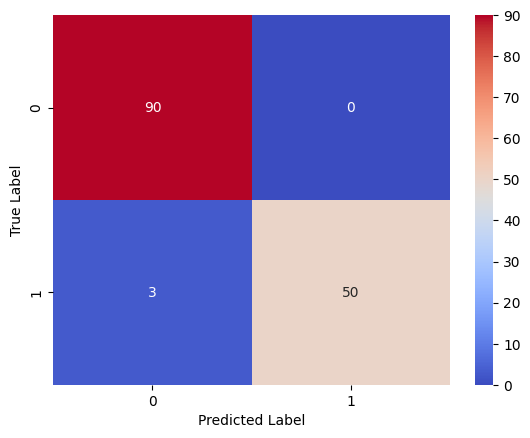

In [5]:
sns.heatmap(confusion, cmap='coolwarm', xticklabels=True, yticklabels=True, annot=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
# This shows
# True Positives | False Negatives
# False Positives | True Negatives

From this, we can build various metrics. For example, the error: $$ERR = \frac{FP + FN}{FP + FN + TP + TN},$$ the prediction accuracy: $$ACC = 1- ERR = \frac{TP + TN}{FP + FN + TP + TN},$$ the **Recall** or True Positive Rate (TPR): $$REC = TPR = \frac{TP}{P} = \frac{TP}{FN + TP},$$  the False Positive Rate (FPR): $$ FPR = \frac{FP}{N} = \frac{FP}{FP + TN},$$ and **Precision**: $$PRE = \frac{TP}{\mathrm{classified \,} P} = \frac{TP}{TP + FP}.$$

When you can't afford to miss out on succesfully identifying the positive cases, even if you flag a few of the negative ones (diagnosing diseases), high recall/tpr is vital.

When you can't for your positive predictions to go wrong, high precision is important (labeling someone a criminal when they are not, or flagging an email for spam when it is not).

When you can't afford to get your negative predictions wrong, a low FPR is key (flip side of precision - of all people flagged as innocent, how many were guilty).

High precision is important when you need to be sure to not misclassify things as positive when they are not. High recall is important when it is important to not miss any positive classifications. To balance between them, we aim for a high F1 score: $$F1 = 2 \frac{PRE \times REC}{PRE + REC} = \mathrm{mean}\left(\frac{1}{PRE} , \frac{1}{REC}\right)^{-1}.$$

The F1 score doesn't really care about the true negatives in any way. An alternative that takes all 4 pieces into account is the MCC (Matthews Correlation Coefficient): $$MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}.$$

This ranges from -1 to 1, and is supposed to be robust, even if less interpretable.

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
pred = clf.predict(X_test)

print(f"Precision: {precision_score(y_true=y_test, y_pred=pred):3f}")
print(f"Recall: {recall_score(y_true=y_test, y_pred=pred):3f}")
print(f"F1: {f1_score(y_true=y_test, y_pred=pred):3f}")
print(f"MCC: {matthews_corrcoef(y_true=y_test, y_pred=pred):3f}")

Precision: 1.000000
Recall: 0.943396
F1: 0.970874
MCC: 0.955492


In [8]:
# We can also define custom scoring - perhaps we want 0 to be out positive label instead of 1, and to use the F1 score
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

# This can then be passed into out grid search
gs_svc = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  refit=True, # Refits to the whole training set automatically after finding the best one
                  n_jobs=-1).fit(X_train, y_train)

print(gs_svc.best_score_)

0.9811466027234221


Using the FPR and TPR, we can define the ROC as TPR vs FPR. The ROC smoothly varies as the decision threshold of the classifier shifts. Perfect classifier - TPR = 1, FPR = 0 (top left of the quadrant). Rnadom guessing -> diagonal curve. The metric to draw from this is the AUC ROC.

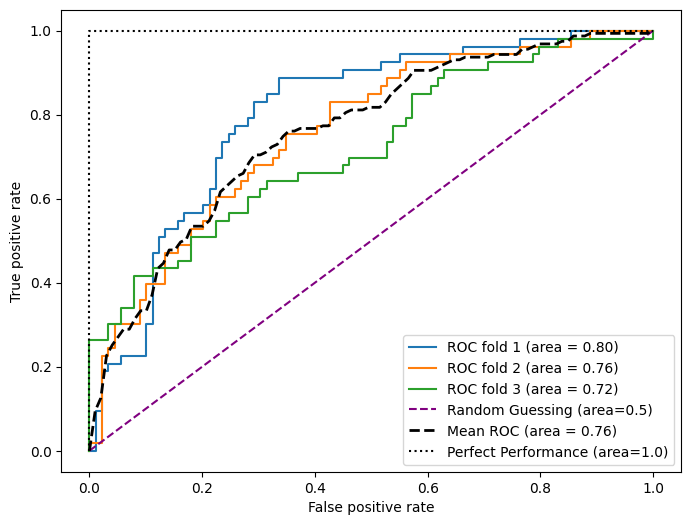

In [19]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', random_state=42))

# Use only 2 features to challenge the classifier, and only do 3 fold CV
X_train_2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(8,6))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probs = pipe_lr.fit(X_train_2[train], y_train[train]).predict_proba(X_train_2[test])
    fpr, tpr, thresholds = roc_curve(y_true=y_train[test], y_score=probs[:, 1], pos_label=1)

    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"ROC fold {i+1} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1],
         linestyle='--', color='purple', label="Random Guessing (area=0.5)")

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='black', label="Perfect Performance (area=1.0)")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

In the case on multi-label classification such as an OvR scheme (One versus Rest), these metrics can be reevaluated in the context of all of the prior formular, summed over the cases to create micro and macro averages. The micro averages are constructed by summing over a system with $k$ classes or labels. For example, $$PRE_{micro} = \frac{TP_1 + \cdots + TP_k}{TP_1 + \cdots + TP_k + FP_1 + \cdots FP_k}.$$

The macro case is simply the average of the micro: $$PRE_{macro} = \frac{PRE_{micro}}{k}$$

"Micro-averaging is useful if we want to weight each instance or prediction equally, whereas macro-averaging weights all classes equally to evaluate the overall performance of a classifier with regard to the most frequent class labels." - Sebastian Raschka

The macro average or weighted macro average is the default for scikit-learn, but the 'micro' keyword can be used to choose that.

In [ ]:
# sklearn has these implemented already

precision_scorer = make_scorer(score_func=precision_score,
                               pos_label=1,
                               greater_is_better=True,
                               average='micro')